In [1]:
import pickle 
import torch as th
from torch_geometric.explain import Explainer, CaptumExplainer
import torch.nn.functional as F
import torch
from torch_geometric.nn.models.basic_gnn import GraphSAGE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import from_dgl

with open('interm/BoT-IoT_reduced_linegraph_jul29.pkl', 'rb') as f:
    G = pickle.load(f)
    
test_loader = NeighborLoader(
    G,
    num_neighbors=[10] * 3,
    batch_size=128,
    shuffle=False,
    num_workers=6,
    input_nodes=G.test_mask
)


/home/taznk/COMP4003/venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/home/taznk/COMP4

In [32]:
import numpy as np

model = GraphSAGE(
    49,
    hidden_channels=256,
    out_channels=5,
    num_layers=3,
).to(device)

model.load_state_dict(th.load('interm/GraphSAGE_BoTIoT.pth'))
model.eval()

def fidelity(pred_orig, pred_masked, y):
    return  (
        np.array(pred_orig == y, dtype=int) - np.array(pred_masked == y, dtype=int)
    ).mean()
    

/tmp/ipykernel_936259/2760749086.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('interm/GraphSAGE_BoTIoT.pth'))


### GNNEx, DE

In [29]:
import copy
from tqdm import tqdm
from torch_geometric.data import Batch
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.explain.algorithm import DummyExplainer
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import CaptumExplainer, GNNExplainer

def expl(explainer, G):
    explanations = []
    for batch in tqdm(test_loader):
        assert batch.edge_index.shape[0] == 2
        explanations.append(
            explainer(
                x=batch.x.to(device),
                edge_index=batch.edge_index.to(device),
            )
        )
        
    return explanations 

explanations = {}

for name, explainer_object in {
    'GNNE': GNNExplainer(100),
    'DE': DummyExplainer(),
    # 'IG': CaptumExplainer( 'IntegratedGradients'),
    # 'SA': CaptumExplainer('Saliency')
    }.items():

    print(name)
    explanations[name] = expl(
        G=copy.deepcopy(G),
        explainer=Explainer(
            model=model,
            algorithm=explainer_object,
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type=None,
            model_config=ModelConfig(
                mode='multiclass_classification',
                task_level='node',
                return_type='raw',
            ),
        )
    )
    print(explanations[name].shape, explanations[name])
    
    break
    

GNNE


  3%|▎         | 8/233 [00:44<21:03,  5.62s/it]


KeyboardInterrupt: 

### IG

In [8]:
import torch
from tqdm import tqdm

def integrated_gradients_batch(x, edge_index, targets, model, baseline, steps):
    device = x.device
    if baseline is None:
        baseline = torch.zeros_like(x, device=device)

    diff = x - baseline
    total_grads = torch.zeros_like(x, device=device)

    for alpha in torch.linspace(0.0, 1.0, steps, device=device):
        x_scaled = baseline + alpha * diff
        x_scaled.requires_grad_(True)

        # forward pass
        out = model(x_scaled, edge_index)
        
        # pick the logit for each root node & assume root nodes are first B rows
        batch_size = targets.size(0)
        sel = out[:batch_size, :] 
        chosen = sel[torch.arange(batch_size), targets]

        # sum to get a scalar and backprop
        model.zero_grad()
        torch.autograd.backward(chosen.sum(), retain_graph=True)
        grads = x_scaled.grad

        total_grads += grads
        x_scaled.grad.zero_()

    # average gradient then scale by input delta
    avg_grads = total_grads / steps
    attributions = diff * avg_grads 

    return attributions


model.eval()
all_attr, all_delta = [], []

for batch in tqdm(test_loader):
    batch = batch.to(device)
    x = batch.x
    edge_index = batch.edge_index
    root_idx = torch.arange(batch.batch_size, device=device)
    targets = batch.Attack[root_idx]

    # compute attributions
    ig_attr = integrated_gradients_batch(
        x=x,
        edge_index=edge_index,
        targets=targets,
        model=model,
        baseline=torch.zeros_like(x),
        steps=100
    )

    # extract only root nodes’ attributions
    root_attr = ig_attr[root_idx]
    all_attr.append(root_attr)


100%|██████████| 233/233 [08:36<00:00,  2.22s/it]


In [ ]:
import numpy as np

fidelity_plus, fidelity_minus = {}, {}

for batch, attr in tqdm(zip(test_loader, all_attr)):
    batch = batch.to(device)
    x = batch.x.clone()
    y = batch.Attack.clone()
    edge_index = batch.edge_index
    root_idx = torch.arange(batch.batch_size, device=device)
    targets = batch.Attack[root_idx]

    # pred
    with torch.no_grad():
        out_orig = model(x, edge_index)[root_idx]
        pred_orig = out_orig.argmax(dim=1)
        
    for sparsity_percent in np.arange(0, 0.2, 0.005):
        abs_attr = attr.abs()
        k = int(sparsity_percent * x.size(1))
        topk_idx = abs_attr.topk(k, dim=1).indices

        mask = torch.zeros_like(attr, device=device) 
        mask.scatter_(1, topk_idx, 1) 

        # Mask input features
        x_masked = x.clone()
        x_masked[root_idx] = x_masked[root_idx] * mask # ! only masks the root nodes ??

        # Prediction after masking
        with torch.no_grad():
            out_masked = model(x_masked, edge_index)[root_idx]
            pred_masked = out_masked.argmax(dim=1)
            
        # fidelity = (pred_orig != pred_masked).float().mean().item()
        fidelity_minus[sparsity_percent] = fidelity(pred_orig, pred_masked, y[root_idx])
        # fidelity_minus[sparsity_percent] = fidelity(pred_orig, , y[root_idx])

0it [00:00, ?it/s]

128


/tmp/ipykernel_936259/2760749086.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(pred_orig == y, dtype=int) - np.array(pred_masked == y, dtype=int)
1it [00:00,  1.54it/s]

128


2it [00:01,  2.00it/s]

128


3it [00:01,  2.18it/s]

128


4it [00:01,  2.35it/s]

128


5it [00:03,  1.15it/s]

128


5it [00:04,  1.15it/s]


KeyboardInterrupt: 

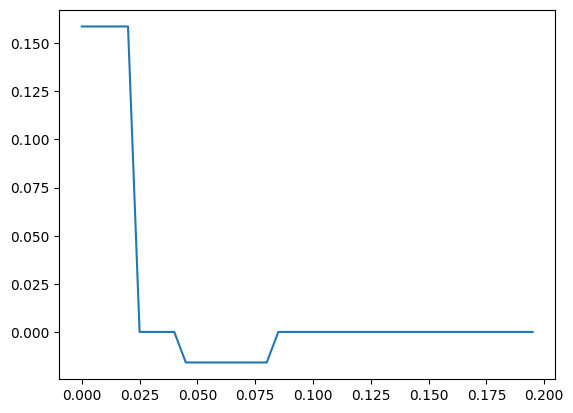

In [31]:
import matplotlib.pyplot as plt

plt.plot(*zip(*fidelity_minus.items()))

In [61]:
points

[0.1428571492433548]

get a thorough evluation setup